## Import libraries

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

In [4]:
data.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


## Answer Questions

### Q1. Read the data for January. How many columns are there?

In [5]:
data.shape

(3066766, 19)

### Q2. What's the standard deviation of the trips duration in January?

In [6]:
data['duration_m'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.seconds / 60
np.std(data['duration_m'])

41.62918432251384

### Q3. Let's remove the `duration` outliers and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [7]:
ix_outliers = (data['duration_m'] < 1) | (data['duration_m'] > 60)
n_outliers = ix_outliers.sum()

In [8]:
n_records = data.shape[0]
print((n_records - n_outliers)/n_records)

0.9812212604417814


### Q4. Let's apply one-hot encoding to the pickup and dropoff location IDs

What's the dimensionality of this matrix (number of columns)?



Remove outliers

In [9]:
data = data[(data['duration_m'] >= 1) & (data['duration_m'] <= 60)]
data.shape

(3009176, 20)

In [10]:
categorical = ['PULocationID', 'DOLocationID']
data[categorical] = data[categorical].astype(str)

Fit a DictVectorizer to extract a OHE from both `PULocationID` and `DOLocationID`

In [11]:
data_dicts = data[categorical].to_dict('records')
v = DictVectorizer(sparse=True) # It is important to set sparse as True to not create a sparse Matrix
X = v.fit_transform(data_dicts)

In [12]:
target = 'duration_m'
y = data[target].values

### Q5. Training a model. RMSE on train

In [13]:
X.shape, y.shape

((3009176, 515), (3009176,))

In [14]:
# Train a linear regressor
reg = LinearRegression().fit(X, y)

Get the predictions

In [16]:
y_pred = reg.predict(X)

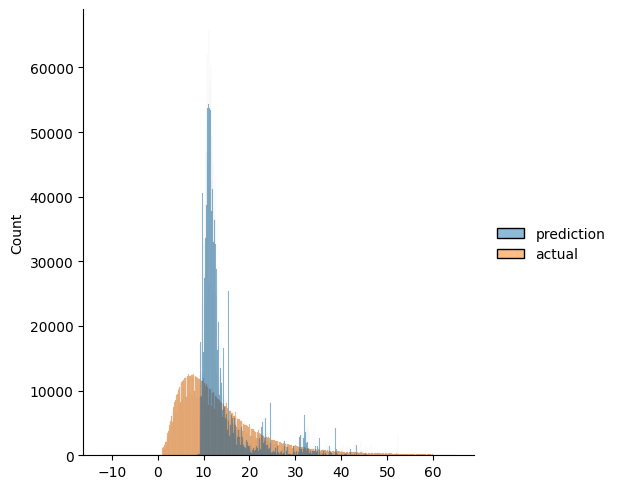

In [17]:
sns.displot(data={'prediction': y_pred, 'actual': y})

In [18]:
y_pred = reg.predict(X)
np.sqrt(mean_squared_error(y, y_pred))

7.649261216494673

Testing on evaluation

In [19]:
data_test = pd.read_parquet('../data/yellow_tripdata_2023-02.parquet')

In [20]:
data_test.shape

(2913955, 19)

Extract the target

In [21]:
data_test['duration_m'] = (data_test['tpep_dropoff_datetime'] - data_test['tpep_pickup_datetime']).dt.seconds / 60

Delete outliers

In [22]:
data_test = data_test[(data_test['duration_m'] >= 1) & (data_test['duration_m'] <= 60)]

In [23]:
data_test.shape

(2855951, 20)

Apply `DictVectorizer` to data

In [24]:
categorical = ['PULocationID', 'DOLocationID']
data_test[categorical] = data_test[categorical].astype(str)

In [25]:
test_dicts = data_test[categorical].to_dict('records')

In [26]:
X_test = v.transform(test_dicts) # v -> DictVectorizer
y_test = data_test[target].values

In [27]:
X_test.shape, y_test.shape

((2855951, 515), (2855951,))

Get predictions

In [28]:
y_pred = reg.predict(X_test)

In [29]:
np.sqrt(mean_squared_error(y_test, y_pred))

7.811815349529803